# 트리플과 지식 그래프
트리플은 지식을 표현하는 최소 단위입니다. 주어(Subject) - 서술어(Predicate) - 목적어(Object)의 세 요소로 구성되죠.
- 예: [강남역] - [위치한다] - [서울]

트리플이 수없이 많이 모이면 지식 그래프(Knowledge Graph)가 됩니다.

# [실습] MovieLens 데이터를 활용한 지식 그래프 구축

본 실습에서는 수동으로 트리플을 입력하는 단계를 넘어, 대량의 CSV 데이터를 파이썬(rdflib)을 사용하여 지식 그래프로 변환하는 자동화 파이프라인을 구축합니다

- MovieLens 데이터셋 다운로드 링크: https://grouplens.org/datasets/movielens/latest/

# 1. 환경 설정 및 데이터 로드
실습을 위해 필요한 라이브러리를 설치하고, MovieLens 데이터셋을 로드합니다.

In [6]:
# 필요한 라이브러리 설치 (최초 1회 실행)
!pip install rdflib pandas pyvis

import pandas as pd
from rdflib import Graph, Literal, RDF, Namespace, URIRef
from rdflib.namespace import XSD

# 데이터 로드
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

print(f"영화 데이터: {len(movies_df)}건")
print(f"평점 데이터: {len(ratings_df)}건")

Defaulting to user installation because normal site-packages is not writeable
영화 데이터: 9742건
평점 데이터: 100836건


In [10]:
movies_df[movies_df['genres'].str.contains('Adventure')] #.count()
# → 1263개 영화에서 "Adventure" 사용

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
7,8,Tom and Huck (1995),Adventure|Children
9,10,GoldenEye (1995),Action|Adventure|Thriller
12,13,Balto (1995),Adventure|Animation|Children
...,...,...,...
9710,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi
9713,188301,Ant-Man and the Wasp (2018),Action|Adventure|Comedy|Fantasy|Sci-Fi
9717,188833,The Man Who Killed Don Quixote (2018),Adventure|Comedy|Fantasy
9720,189333,Mission: Impossible - Fallout (2018),Action|Adventure|Thriller


# 2. 지식 그래프를 위한 네임스페이스(주소) 설정
데이터를 지식 그래프화하기 위해서는 각 개체에 고유한 주소(URI)를 부여해야 합니다. 이를 위해 네임스페이스를 설정합니다.

In [2]:
# 지식 그래프를 위한 네임스페이스 설정
MV = Namespace("http://movielens.org/movie/")
USER = Namespace("http://movielens.org/user/")
GENRE = Namespace("http://movielens.org/genre/")
EVENT = Namespace("http://movielens.org/event/") # 평점 사건을 위한 핵심 노드
SCHEMA = Namespace("http://schema.org/")

g = Graph()
g.bind("movie", MV)
g.bind("user", USER)
g.bind("genre", GENRE)
g.bind("schema", SCHEMA)

# 3. 지식 그래프 구축 자동화
CSV의 각 행(Row)을 순회하며 트리플로 변환합니다. 특히 장르 정제와 이벤트 중심 설계에 집중합니다.

In [3]:
# 3-1. 영화 및 장르 정보 구축
for _, row in movies_df.iterrows():
    movie_uri = MV[str(row['movieId'])]
    g.add((movie_uri, RDF.type, SCHEMA.Movie))
    g.add((movie_uri, SCHEMA.name, Literal(row['title'])))
    
    # 장르 정제 및 연결
    for genre in row['genres'].split('|'):
        # 특수문자 제거로 안전한 URI 생성
        safe_genre = genre.replace("(", "").replace(")", "").replace(" ", "").replace("-", "")
        genre_uri = GENRE[safe_genre]
        
        g.add((movie_uri, SCHEMA.genre, genre_uri))
        g.add((genre_uri, RDF.type, SCHEMA.Genre))
        g.add((genre_uri, SCHEMA.name, Literal(genre)))

# 3-2. 평점 사건(Review)을 통한 관계 통합
# 샘플링 (전체 데이터가 너무 많을 경우 상위 5000건만 먼저 테스트)
for index, row in ratings_df.head(5000).iterrows():
    user_uri = USER[str(int(row['userId']))]
    movie_uri = MV[str(int(row['movieId']))]
    event_uri = EVENT[f"rating_{index}"] # 각 리뷰를 독립된 노드로 관리
    
    g.add((event_uri, RDF.type, SCHEMA.Review))
    g.add((event_uri, SCHEMA.author, user_uri))
    g.add((event_uri, SCHEMA.itemReviewed, movie_uri))
    g.add((event_uri, SCHEMA.ratingValue, Literal(row['rating'], datatype=XSD.float)))

print(f"구축 완료! 생성된 총 트리플 수: {len(g)}")

구축 완료! 생성된 총 트리플 수: 61608


# 4. 지식 그래프 시각화 (Interactive Graph)
pyvis를 사용하여 거대한 지식망을 직접 눈으로 확인합니다.

조회 중인 사용자 URI: http://movielens.org/user/1


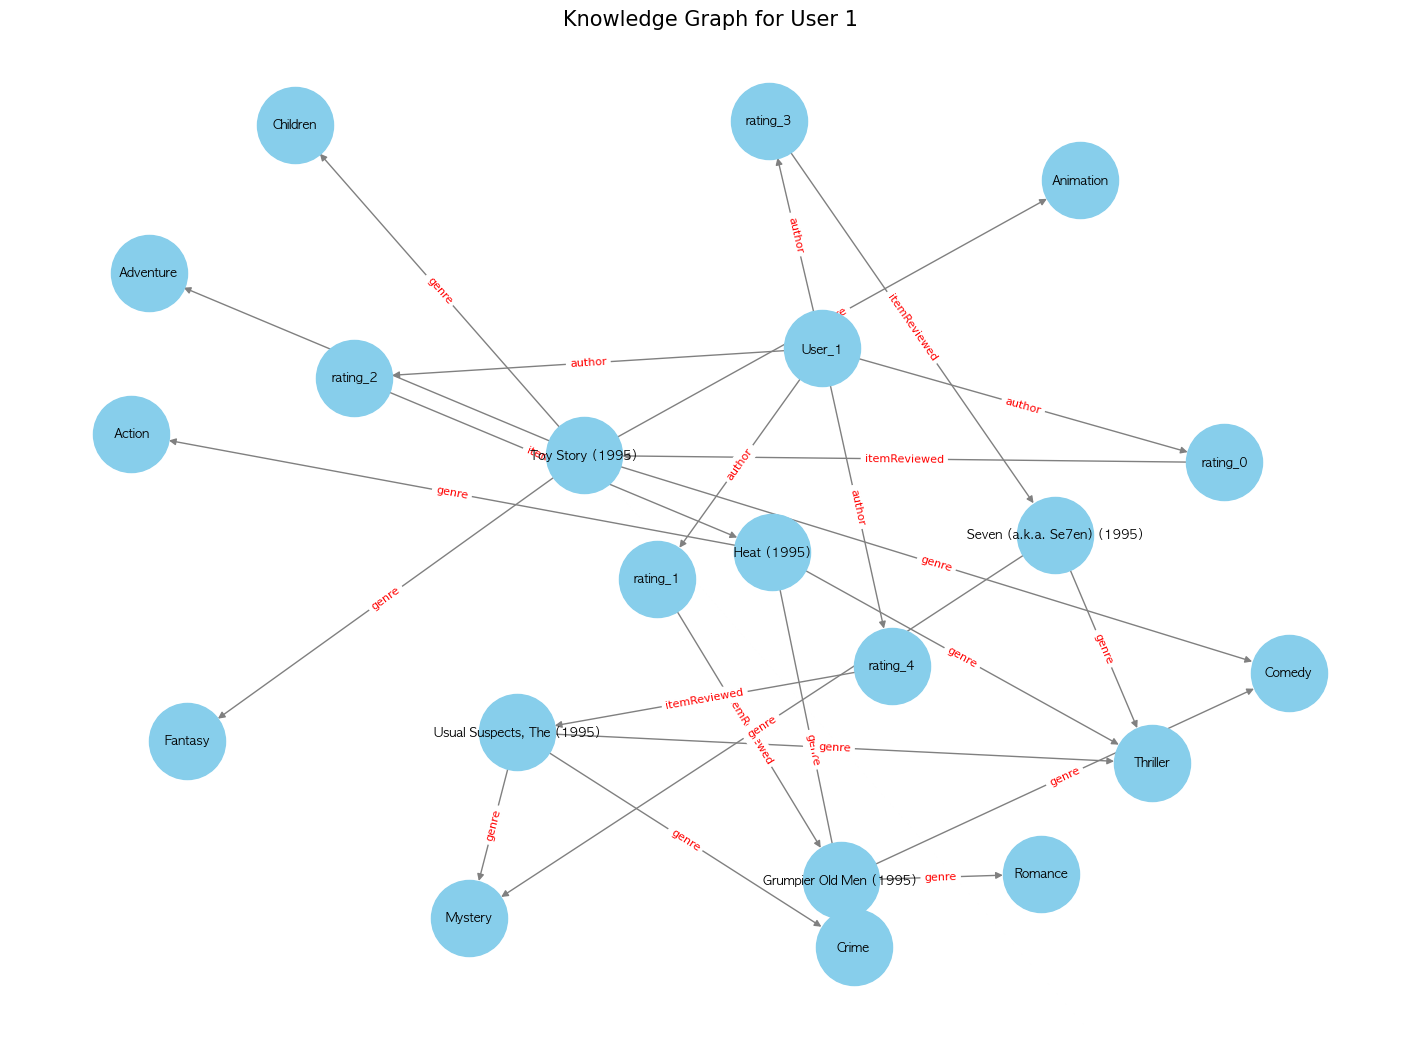

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_user_knowledge(g, user_id="1", max_items=10):
    G = nx.DiGraph()
    
    # 정확한 사용자 URI 생성 (Namespace 설정에 따라 MV, USER 등을 사용)
    # 여기서는 "http://movielens.org/user/1" 형태를 직접 찾습니다.
    target_user_uri = USER[str(user_id)]
    
    print(f"조회 중인 사용자 URI: {target_user_uri}")

    # 1. 사용자가 작성한 리뷰(Review)들 찾기
    count = 0
    for review, p, u in g.triples((None, SCHEMA.author, target_user_uri)):
        if count >= max_items: break
        
        # 라벨 추출 (URI의 마지막 부분)
        u_label = "User_" + str(user_id)
        r_label = str(review).split('/')[-1]
        
        # 사용자 -> 리뷰 연결
        G.add_edge(u_label, r_label, label="author")
        
        # 2. 해당 리뷰가 가리키는 영화(Movie) 찾기
        for r, p2, movie in g.triples((review, SCHEMA.itemReviewed, None)):
            # 영화 제목 가져오기 (SCHEMA.name 속성 사용)
            m_name = str(g.value(movie, SCHEMA.name))
            m_label = m_name if m_name else str(movie).split('/')[-1]
            
            # 리뷰 -> 영화 연결
            G.add_edge(r_label, m_label, label="itemReviewed")
            
            # 3. 영화의 장르(Genre) 정보까지 연결 (선택 사항)
            for m, p3, genre in g.triples((movie, SCHEMA.genre, None)):
                g_label = str(g.value(genre, SCHEMA.name))
                G.add_edge(m_label, g_label, label="genre")
        
        count += 1

    if len(G.nodes) == 0:
        print("그래프에 노드가 없습니다. 사용자 ID나 데이터 로드 상태를 확인하세요.")
        return

    # 시각화 설정
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=1.2, seed=42)
    
    nx.draw(G, pos, with_labels=True, 
            node_color='skyblue', node_size=3000, 
            font_size=9, font_family='AppleGothic', # 한글 깨짐 방지 (윈도우는 'Malgun Gothic')
            arrows=True, edge_color='gray')
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    
    plt.title(f"Knowledge Graph for User {user_id}", size=15)
    plt.show()

# 실행
visualize_user_knowledge(g, user_id="1", max_items=5)

# 5. SPARQL을 이용한 지식 탐색
단순 데이터베이스 쿼리보다 강력한 그래프 탐색을 수행합니다.

In [5]:
# 사용자 1번이 고득점(4.0 이상)을 준 영화의 장르 통계
query = """
PREFIX schema: <http://schema.org/>
SELECT ?genreName (COUNT(?movie) AS ?count)
WHERE {
    ?event schema:author <http://movielens.org/user/1> ;
           schema:ratingValue ?rating ;
           schema:itemReviewed ?movie .
    FILTER(?rating >= 4.0)
    
    ?movie schema:genre ?genre .
    ?genre schema:name ?genreName .
}
GROUP BY ?genreName
ORDER BY DESC(?count)
LIMIT 5
"""

print("--- 사용자 1번의 선호 장르 분석 ---")
for row in g.query(query):
    print(f"장르: {row[0]:15} | 선호도(영화 수): {row[1]}편")

--- 사용자 1번의 선호 장르 분석 ---
장르: Action          | 선호도(영화 수): 90편
장르: Adventure       | 선호도(영화 수): 85편
장르: Comedy          | 선호도(영화 수): 83편
장르: Drama           | 선호도(영화 수): 68편
장르: Thriller        | 선호도(영화 수): 55편
